In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.integrate import odeint, solve_ivp
from scipy.stats import linregress
from scipy.misc import derivative
from collections import namedtuple
from scipy.optimize import minimize, dual_annealing, shgo, differential_evolution, basinhopping
from tqdm.notebook import tqdm

In [2]:
def read_data_for_country(country, province, directory):
    rus_confirmed = {}
    rus_death = {}
    rus_recovered = {}

    for file in os.listdir(directory):
        if file.endswith('csv'):
            temp = pd.read_csv(directory+file)
            if 'Province/State' in temp.columns:
                death_series = temp.loc[(temp['Country/Region']==country) & (temp['Province/State']==province), 'Deaths']
                confirmed_series = temp.loc[(temp['Country/Region']==country) & (temp['Province/State']==province), 'Confirmed']
                recovered_series = temp.loc[(temp['Country/Region']==country) & (temp['Province/State']==province), 'Recovered']
            else:
                death_series = temp.loc[(temp['Country_Region']==country) & (temp['Province_State']==province), 'Deaths']
                confirmed_series = temp.loc[(temp['Country_Region']==country) & (temp['Province_State']==province), 'Confirmed']
                recovered_series = temp.loc[(temp['Country_Region']==country) & (temp['Province_State']==province), 'Recovered']

            time = pd.Timestamp(file[:-4])

            if confirmed_series.shape[0] > 0:
                rus_confirmed[time] = confirmed_series.iloc[0]
            if death_series.shape[0] > 0:
                rus_death[time] = death_series.iloc[0]
            if recovered_series.shape[0] > 0:
                rus_recovered[time] = recovered_series.iloc[0]

    rus_confirmed = pd.Series(rus_confirmed).fillna(0).astype(int)
    rus_death = pd.Series(rus_death).fillna(0).astype(int)
    rus_recovered = pd.Series(rus_recovered).fillna(0).astype(int)
    
    return pd.DataFrame({'confirmed': rus_confirmed.values, 
                         'death': rus_death.values, 
                         'recovered': rus_recovered.values},
                       index=rus_confirmed.index)

def read_timeseries_for_country(country, directory):
    if country in ['China', 'Canada', 'Australia']:
        return read_timeseries_for_country_all_provinces(country, directory)
    
    conf_data = pd.read_csv(directory + 'time_series_covid19_confirmed_global.csv')
    recov_data = pd.read_csv(directory + 'time_series_covid19_recovered_global.csv')
    death_data = pd.read_csv(directory + 'time_series_covid19_deaths_global.csv')

    index = [pd.Timestamp(d) for d in conf_data.columns[4:]]
    conf_data = conf_data[(conf_data['Country/Region']==country) & (conf_data['Province/State'].isna())].iloc[0,4:]
    recov_data = recov_data[(recov_data['Country/Region']==country) & (recov_data['Province/State'].isna())].iloc[0,4:]
    death_data = death_data[(death_data['Country/Region']==country) & (death_data['Province/State'].isna())].iloc[0,4:]
    
    return pd.DataFrame({'confirmed': conf_data.values, 
                        'recovered': recov_data.values,
                        'death': death_data.values},
                       index=index).astype(int)

In [3]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 15

# Модель SEIR для предсказания распространения COVID-19

SEIR - модель из семейства полигамных моделей, описывающих распространение эпидемии.

${\frac {dS}{dt}}=\mu N-\mu S-\beta {\frac {I}{N}}S$  
${\frac {dE}{dt}}=\beta {\frac {I}{N}}S-(\mu +a)E$  
${\frac {dI}{dt}}=aE-(\gamma +\mu )I$  
${\frac {dR}{dt}}=\gamma I-\mu R$

$S(t)$ - (Susceptible) количество людей, подверженных заражению.  
$E(t)$ - (Exposed) количество носителей, т.е. заражённых людей, у которых болезнь еще не проявилась из-за инкубационного периода.   
$I(t)$ - (Infectious) - инфецированные.  
$R(t)$ - (Recovered) - выздоровевшие.  
$N = S + E + I + R$ - численность популяции. Она сохраняется постоянной, т.е. предполагается, что от болезни никто не умирает.  
$\mu$ - уровень естественной смертности.  
$\alpha$ - величина, обратная инкубационному периоду заболевания.  
$\gamma$ - величина, обратная среднему времени выздоровления.  
$\beta$ - коэффициент интенсивности контактов, приводящих к заражению.  

Жизненный цикл индивида в SEIR:

<img src="files/SEIR.PNG">

* Здоровый, но ещё не переболевший человек (Susceptible) может заразиться от инфицированного (Infectious) человека. Вероятность, с которой здоровый человек заразится описывается параметром $\beta$.
* Заразившийся человек переходит в состояние носителя инфекции (Exposed). Носители - это люди, у которых заболевание ещё не проявилось, т.е. у них протекает инкубационный период. Носители не могут никого заразить. Переход подверженных заболеванию людей в состояние носителей описывается двумя первыми уравнениями модели (посредством слагаемого $\beta {\frac {I}{N}}S$)
* Через $1/\alpha$ дней (инкубационный период) после заражения носитель переходит в состояние инфицированного (Infectious). 
* Через $1/\gamma$ дней (время выздоровления), инфицированный переходит в состояние выздоровевшего (Recovered). У выздоровевшего человека вырабатывается иммунитет и он больше не может заразиться этой инфекцией.
* Также, модель предусматривает естественную смертность населения в популяции. Смертность в SEIR модели сбалансирована рождаемостью, поэтому общая численность населения не меняется. Выздоровевшие люди рано или поздно умрут и заместятся новорожденными, которые иммунитет уже иметь не будут. Поэтому со временем количество выздоровевших людей в популяции уменьшается. Интенсивность смертности описывается параметром $\mu$.  
Типичное решение SEIR модели выглядит так:

In [4]:
from scipy.integrate import odeint, solve_ivp

def deriv(t, y, betas, gamma, alpha):
    S, E, I, R = y
    N = S+E+I+R
    dSdt = -betas[int(t)]*S*I/N
    dEdt = betas[int(t)]*S*I/N - alpha*E
    dIdt = alpha*E - gamma*I
    dRdt = gamma*I
    return dSdt, dEdt, dIdt, dRdt

def solve_seir(S0, E0, I0, R0, betas, gamma, alpha, times):
    
    N0 = S0+E0+I0+R0
    global deriv_count
    deriv_count = 0
    
    y0 = S0, E0, I0, R0
    ret = solve_ivp(deriv, t_span=(0, times[-1]), y0=y0, t_eval=times, args=(betas, gamma, alpha))
    S, E, I, R = ret.y
    return S, E, I, R


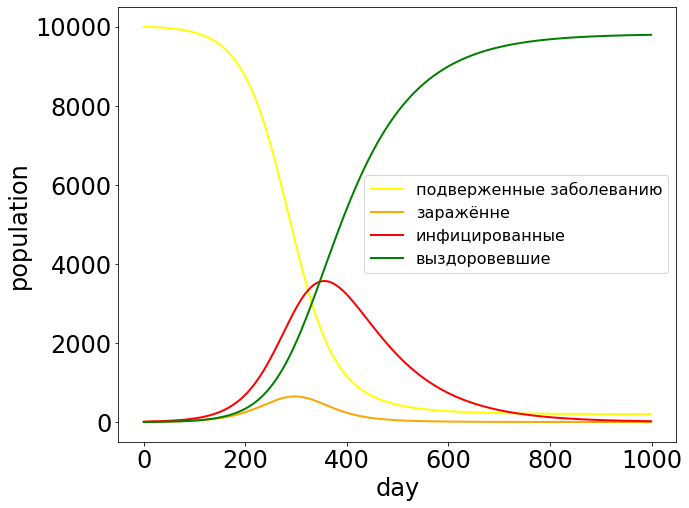

In [5]:
S, E, I, R = solve_seir(S0=10_000, E0=5, I0=10, R0=0,
                        betas=[0.04]*1000, gamma=0.01, alpha=0.08, times=np.arange(0, 1000,1))
plt.rcParams['legend.fontsize'] = 16
plt.figure(figsize=(10, 8))
plt.plot(S, color='yellow', label='подверженные заболеванию')
plt.plot(E, color='orange', label='заражённе')
plt.plot(I, color='red', label='инфицированные')
plt.plot(R, color='green', label='выздоровевшие')
plt.xlabel('day')
plt.ylabel('population')
plt.legend()
plt.show()

### Решение модели
Уравнение модели есть, осталось его решить. Для этого нужны начальные условия для всех четырёх функций, а также неизвестные коэффициенты.  
Сделаем первое упрощение модели - т.к. мы рассматриваем развитие эпидемии на достаточно коротком промежутке времени, то будем считать, что естественная смертность населения равна нулю, т.е. $\mu = 0$.  
Также известно, что инкубационный период COVID-19 равен 5.1 день. 
Теперь, все остальные параметры для каждой страны и региона мы можем подобрать по имеющимся данным. После зануления коэффициента смертности $\mu$ и замены операторов дифференцирования на операторы конечной разности, имеем:  

${\Delta S}=-\beta {\frac {I}{N}}S$  
${\Delta E}=\beta {\frac {I}{N}}S-aE$  
${\Delta I}=aE-\gamma I$  
${\Delta R}=\gamma I$  

В качестве оператора конечной разности $\Delta$ в этом решении использована двухсторонняя разность.  
Количество выздоровевших людей $R$ по дням есть в исходных данных, а количество инфицированных $I$ равно количеству подтвержденных случаев минус количество выздоровевших. Так что из последнего уравнения можем найти $\gamma$ с помощью оптимизации целевой функции $\text{MALE}(\Delta R-\gamma I)$. Теперь, из третьего уравнения можно найти $E$, а затем и $S$, т.к. $S=N-I-E-R$ (т.е. заболеванию в любой момент времени подвержено всё населения, кроме тех, кто уже заразился и выздоровел).  

Для того, чтобы проследить, как карантинные мероприятия влияют на развитие эпидемии, немного усложним себе задачу и заменим коэффициент $\beta$ на функцию $\beta(t)$ - ведь по мере того, как в стране вводится карантин, интенсивность заражений должна падать, а значит в нашем случае $\beta$ не будет константой. Т.к. у нас уже есть все начальные условия для решения дифура, вопользуемся оптимизацией для поиска функции $\beta(t)$.

## Запускаем модель

In [6]:
rus_directory='../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
country_directory='../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

In [7]:
rus_regions = pd.read_csv('russia_regions.csv')
countries = pd.read_csv('countries.csv')

Чтобы проиллюстрировать работу модели SEIR на реальных данных, запустим подбор параметров на нескольких примерах. Функцию $\beta(t)$ сначала будем подбирать в виде ступенчатой - с двумя ступеньками. Посмотрим на примере Москвы, а также Италии и Германии.
### Москва

In [8]:
def get_last_N_days(df, N):
    df['date'] = df.index
    cutted_df = (
        df
        .sort_values('date', ascending=False)
        .head(N)
        .sort_values('date', ascending=True)
        .drop(columns=['date'])
    )
    
    return cutted_df

In [9]:
moscow_data = read_data_for_country('Russia', 'Moscow', directory=rus_directory)
moscow_data = get_last_N_days(moscow_data, 120)

In [10]:
moscow_data.head()

,confirmed,death,recovered
2020-08-12,249611,4611,192686
2020-08-13,250303,4622,193473
2020-08-14,250991,4633,194823
2020-08-15,251686,4645,196098
2020-08-16,252374,4656,197143


In [11]:
alpha=1 / 5.1

def plot_ir(I, R, country, country_name, t, ax=None):
    N = np.max(I+R)
    rusN = np.max(country)
    N = np.max([rusN, N])
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    if ax is None:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, I+R, 'r', alpha=0.5, lw=2, label='Заражённые+переболевшие')
    ax.plot(t, I, 'g', alpha=0.5, lw=2, label='Заражённые')
    ax.plot(t, R, 'b', alpha=0.5, lw=2, label='Переболевшие')
    ax.plot(np.arange(0, country.shape[0], 1), country, 'black', alpha=0.5, lw=2, label=country_name)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number')
    ax.set_ylim(0, N+N*0.1)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return ax

def eucl_metric(df1, df2):
    return np.linalg.norm(df1-df2)

def male_metric(df1, df2):
    errors = ((df1 + 1)/(df2 + 1)).apply(np.log10).abs()
    return errors.mean()

def dFdt_twosided(func_df):
    result = np.array([derivative(lambda x: func_df.iloc[x], x0, dx=1, n=1) for x0 in range(1, func_df.shape[0]-1)])
    result = np.hstack([func_df.iloc[1]-func_df.iloc[0], result, func_df.iloc[-1]-func_df.iloc[-2]])
    return pd.Series(result, index=func_df.index)


def find_gamma(data_df, metric=male_metric):
    dRdt = dFdt_twosided(data_df.recovered) # dR/dt ~ R(t+1)-R(t)
    I = (data_df.confirmed - data_df.recovered)
    min_gamma = 0
    min_err = 10000000000
    for gamma in np.logspace(-2, 0, 500):
        err = metric(dRdt, gamma*I)
        if err < min_err:
            min_err = err
            min_gamma = gamma
    return min_gamma, min_err

seir_params = namedtuple('seir_params', ['S', 'E', 'I', 'R', 'N', 'gamma', 'beta', 'gamma_err'])

def compute_scalar_params(data_df, N):
    gamma, gamma_err = find_gamma(data_df)
    I = data_df.confirmed - data_df.recovered
    dIdt = dFdt_twosided(I)
    
    gammaI = gamma*I
    E = (dIdt + gammaI) / alpha
    
    R = data_df.recovered
    S = N - I - E - R # S+E = N-Confirmed
    
    dSdt = dFdt_twosided(S)
    IS_div_N = I * S / N
    beta = -dSdt / IS_div_N # dSdt = -beta*IS_div_N
    
    return seir_params(S, E, I, R, N, gamma, beta, gamma_err)
    

def get_twostep_func(timesunits, x1, x2, x3, middle1, middle2):
    if middle1 > middle2:
        middle1, middle2 = middle2, middle1
    return np.hstack([
        np.ones(middle1)*x1,
        np.ones(middle2-middle1)*x2,
        np.ones(timesunits*100-middle2)*x3
    ])    
    
def twostep_beta_cost_func(x1, x2, x3, middle1, middle2, data_df, seir_params):
    timesunits = seir_params.S.shape[0]
    times = np.arange(0, seir_params.S.shape[0], 1)
    S, E, I, R = solve_seir(
        S0=seir_params.S.iloc[0], 
        E0=seir_params.E.iloc[0],
        I0=seir_params.I.iloc[0],
        R0=seir_params.R.iloc[0],
        betas=get_twostep_func(timesunits, x1, x2, x3, int(middle1), int(middle2)),
        gamma=seir_params.gamma, 
        alpha=alpha, 
        times=times
    )

    return male_metric(I+R, data_df.confirmed)

def optimize_twostep_beta(data_df, seir_params):   
    params = differential_evolution(
        lambda x: twostep_beta_cost_func(x[0], x[1], x[2], x[3], x[4], data_df, seir_params), 
        bounds=[(0, 1), (0, 1), (0, 1), (0, data_df.shape[0]), (0, data_df.shape[0])], 
        seed=157
    )
    
    beta_func = get_twostep_func(
        data_df.shape[0],
        params.x[0], 
        params.x[1], 
        params.x[2], 
        int(params.x[3]), 
        int(params.x[4])
    )
    
    return beta_func, params                     
    
def run_train_test(data_df, 
                   contry_name, N, 
                   cut_koef=500, dot_number=None, test_fold_size=1, beta_opt_func=optimize_twostep_beta):
    
    train_data = data_df.iloc[:-test_fold_size, :]
    
    train_params = compute_scalar_params(train_data, N)
    
    opt_beta, opt_result = beta_opt_func(train_data, train_params)
    
    test_data = pd.concat([train_data, data_df.iloc[-test_fold_size:, :]])
    
    timesunits = test_data.shape[0]
    times = np.arange(0, timesunits, 1)
    S, E, I, R = solve_seir(
                    S0=train_params.S.iloc[0],
                    E0=train_params.E.iloc[0], 
                    I0=train_params.I.iloc[0], 
                    R0=train_params.R.iloc[0], 
                    betas=opt_beta,
                    gamma=train_params.gamma, 
                    alpha=alpha, 
                    times=times
              )
    
    fig = plt.figure(figsize=(15, 4))
    axis = fig.subplots(1, 2)
    
    plot_ir(I, R, test_data.confirmed, contry_name, times, axis[0])
    xticks = times[::10]
    xlabels = train_data.index[::10].map(lambda dt: f'{dt.year}-{dt.month:02d}-{dt.day:02d}')
    min_len = min(xticks.shape[0], xlabels.shape[0])
    axis[0].set_xticks(xticks[:min_len])
    axis[0].set_xticklabels(xlabels[:min_len])
    axis[0].tick_params(axis='x', rotation=90)
    
    axis[1].plot(opt_beta[:train_data.shape[0]])    
    axis[1].set_xticks(xticks)
    axis[1].set_xticklabels(xlabels)
    axis[1].tick_params(axis='x', rotation=90)

    return opt_beta, train_params, S, E, I, R

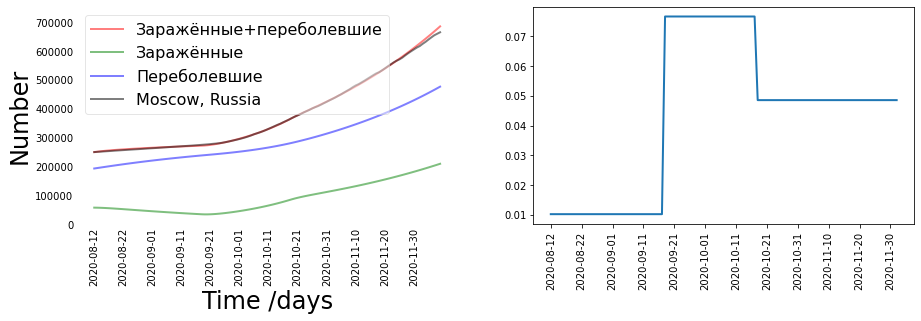

In [12]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
result = run_train_test(moscow_data, 
                        'Moscow, Russia', 
                        N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0],
                        test_fold_size=7, beta_opt_func=optimize_twostep_beta
                       )

### Италия

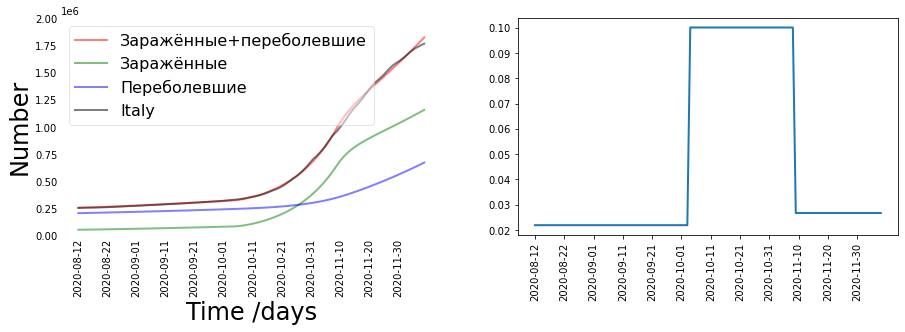

In [13]:
italy_data = read_timeseries_for_country('Italy', directory=country_directory)
italy_data = get_last_N_days(italy_data, N=120)
italy_result = run_train_test(italy_data, 'Italy', 
                           N=countries[countries.ccse_name=='Italy']['population'].iloc[0], 
                           beta_opt_func=optimize_twostep_beta)

### Германия

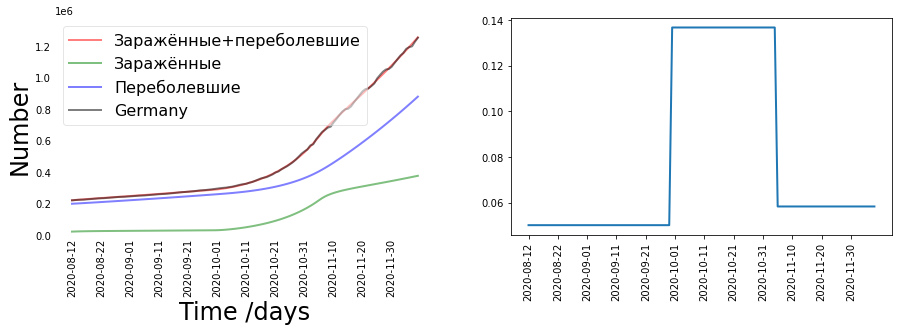

In [14]:
germany_data = read_timeseries_for_country('Germany', directory=country_directory)
germany_data = get_last_N_days(germany_data, N=120)
result = run_train_test(germany_data, 'Germany', 
                           N=countries[countries.ccse_name=='Germany']['population'].iloc[0], 
                           beta_opt_func=optimize_twostep_beta)

# Москва

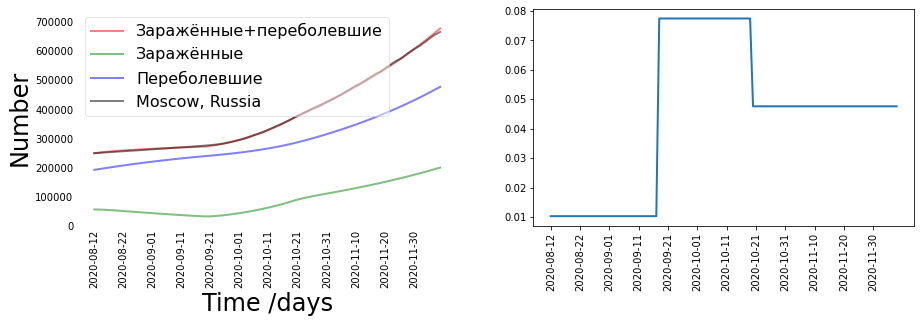

In [15]:
result = run_train_test(moscow_data, 
                        'Moscow, Russia', 
                        N=rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0],
                        test_fold_size=1, beta_opt_func=optimize_twostep_beta
                       )

In [16]:
opt_beta, params, S, E, I, R = result

In [17]:
dR = moscow_data['recovered'].iloc[-1] - moscow_data['recovered'].iloc[-2]
N = rus_regions[rus_regions.csse_province_state=='Moscow']['population'].iloc[0]
I0 = dR / params.gamma
R0 = moscow_data['recovered'].iloc[-1]

dR_prev = moscow_data['recovered'].iloc[-2] - moscow_data['recovered'].iloc[-3]
I_prev = dR_prev / params.gamma
dI = I0 - I_prev
E0 = (params.gamma * I0 + dI) / alpha

S0 = N - I0 - E0 - R0

In [18]:
print (S0, E0, I0, R0)

11905967.938037721 69217.21675280541 210131.84520947465 507149


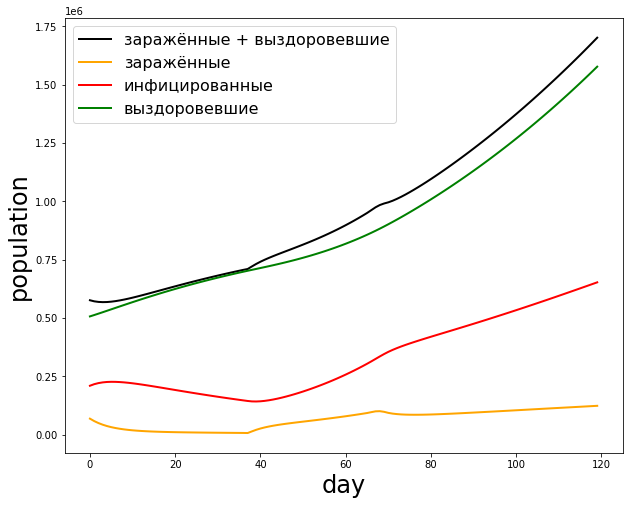

In [19]:
S, E, I, R = solve_seir(
    S0=S0, 
    E0=E0, 
    I0=I0, 
    R0=R0,
    betas=opt_beta, 
    gamma=params.gamma, 
    alpha=alpha, 
    times=np.arange(0, 120,1)
)

plt.rcParams['legend.fontsize'] = 16
plt.figure(figsize=(10, 8))
plt.plot(E + R, color='black', label='заражённые + выздоровевшие')
plt.plot(E, color='orange', label='заражённые')
plt.plot(I, color='red', label='инфицированные')
plt.plot(R, color='green', label='выздоровевшие')
plt.xlabel('day')
plt.ylabel('population')
plt.legend()
plt.show()